# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2 , # Number of pseudo-experiments to run per set
"num_of_sets" : 5, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is /home/chakkappai/Work/Fair-Universe/HEP-Challenge_RC



### Add directories to path

In [6]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = False

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587494 entries, 0 to 587493
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 74.0 MB
None
[*] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [13]:
train_visualize = Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [14]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 587494
[*] --- Number of features : 28
   diboson   2398563.89547613
   htautau   285.4734133092692
   ttbar   616016.6584148749
   wjets   3812700.198884666
   ztautau   7306659.692678657
[*] --- Number of signal events : 495643
[*] --- Number of background events : 91851
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,35.806999,1.991,-0.586,79.801003,1.018,-0.785,185.875000,-0.360,2.885,183.020996,...,331.662994,2.146,37.54,-0.642,0.993,179.164001,596.429993,0.449,1.387,0.242
1,22.094999,1.109,0.400,59.280998,-0.234,-1.971,59.280998,-0.234,-1.971,33.278999,...,51.948002,3.079,-0.00,-0.667,2.725,112.456001,228.888000,0.373,-1.027,0.984
2,20.530001,-0.033,0.061,38.776001,-1.074,3.078,38.776001,-1.074,3.078,-7.000000,...,8.513000,-7.000,-7.00,-7.000,3.192,8.513000,98.081001,0.529,-0.574,-7.000
3,21.837999,-1.549,2.619,24.382000,-2.313,0.101,24.382000,-2.313,0.101,-7.000000,...,12.154000,-7.000,-7.00,-7.000,2.632,12.154000,70.602997,0.896,-1.342,-7.000
4,44.200001,0.108,1.663,37.803001,1.800,-2.030,37.803001,1.800,-2.030,34.285999,...,23.562000,2.232,-0.00,-0.778,3.093,36.768002,154.093002,1.169,-1.227,0.767


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,...,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000
mean,41.518753,0.001016,-0.002035,51.806934,0.001662,0.001886,78.463570,0.000256,-0.000307,36.703117,...,66.652428,-0.742022,10.778684,-2.133732,2.540747,51.703873,242.151810,0.949479,0.409354,-1.869865
std,25.259804,1.165208,1.813845,28.462002,1.198698,1.813327,59.886684,1.551047,1.813591,41.375164,...,70.351128,4.316102,30.836983,4.099448,0.707789,56.638672,161.216248,0.698054,1.128382,3.416090
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.919001,-4.924000,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679001,0.034000,-1.414000,-7.000000
25%,26.245001,-0.881000,-1.572000,34.428001,-0.916000,-1.567000,43.144001,-1.113000,-1.573000,-7.000000,...,18.753000,-7.000000,-7.000000,-7.000000,2.091000,15.371000,134.697006,0.535000,-0.926000,-7.000000
50%,34.261002,0.001000,-0.004000,45.257000,0.003000,0.007000,58.615002,0.001000,0.000000,33.932499,...,41.754002,0.945000,-0.000000,-1.184000,2.762000,32.466000,188.473007,0.772000,1.044000,0.005000
75%,47.282001,0.884000,1.570000,59.625000,0.921000,1.569750,90.880747,1.113000,1.569000,55.430000,...,90.250999,2.372000,15.208000,0.616000,3.072000,70.410753,299.408997,1.131000,1.369000,0.563000
max,1026.430054,2.500000,3.142000,778.645996,2.681000,3.142000,1166.640015,4.924000,3.142000,696.237000,...,1167.008057,7.845000,817.351000,14.638000,5.829000,1797.446045,2939.478027,23.846001,1.414000,1.000000


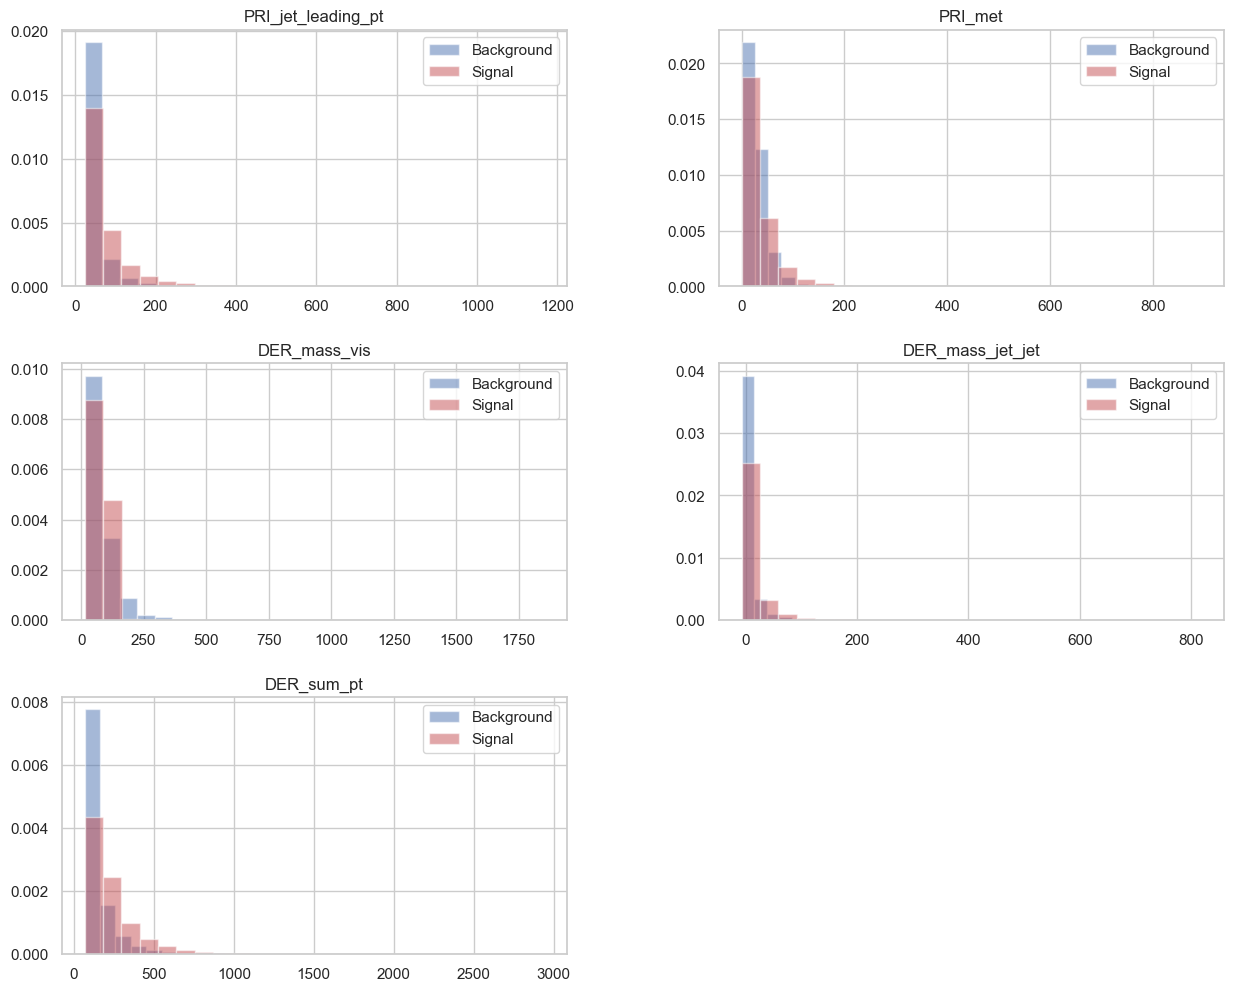

In [15]:
# Show data summary
train_visualize.histogram_dataset()

diboson (1775,)
diboson (1775,)
htautau (30,)
ttbar (60041,)
ttbar (60041,)
wjets (594,)
wjets (594,)
ztautau (29441,)
ztautau (29441,)


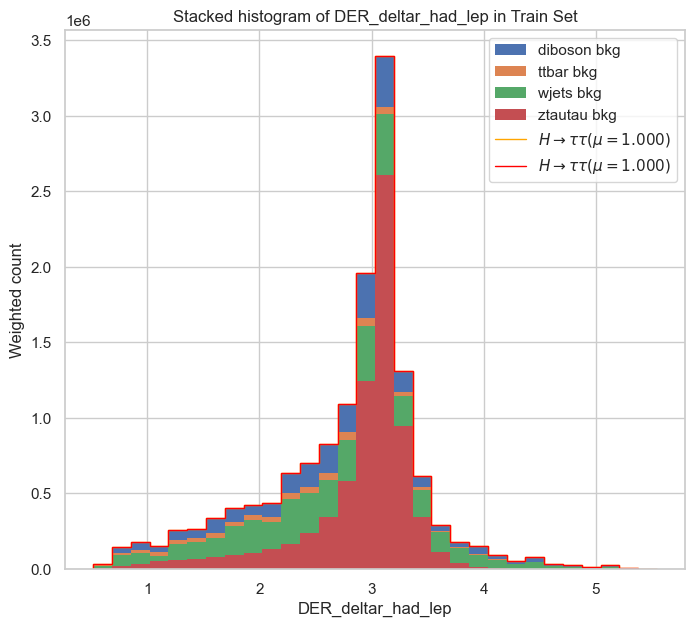

In [16]:
train_visualize.stacked_histogram("DER_deltar_had_lep")

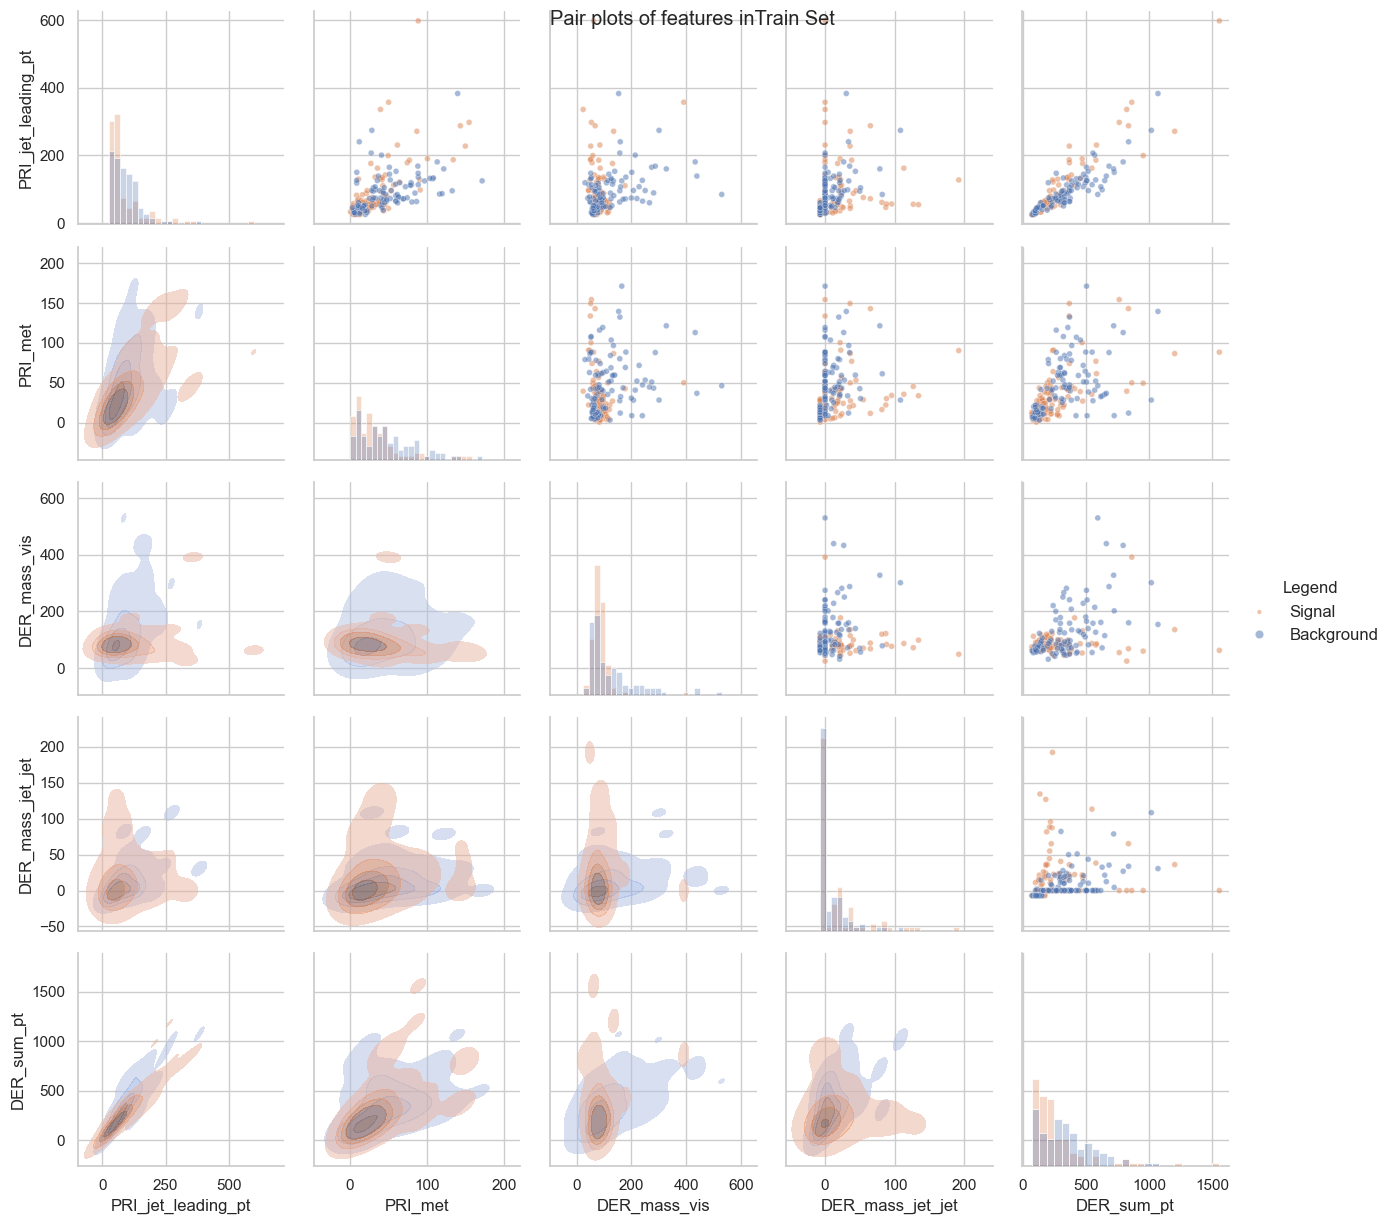

In [17]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [18]:
syst_train_data = data.get_syst_train_set()

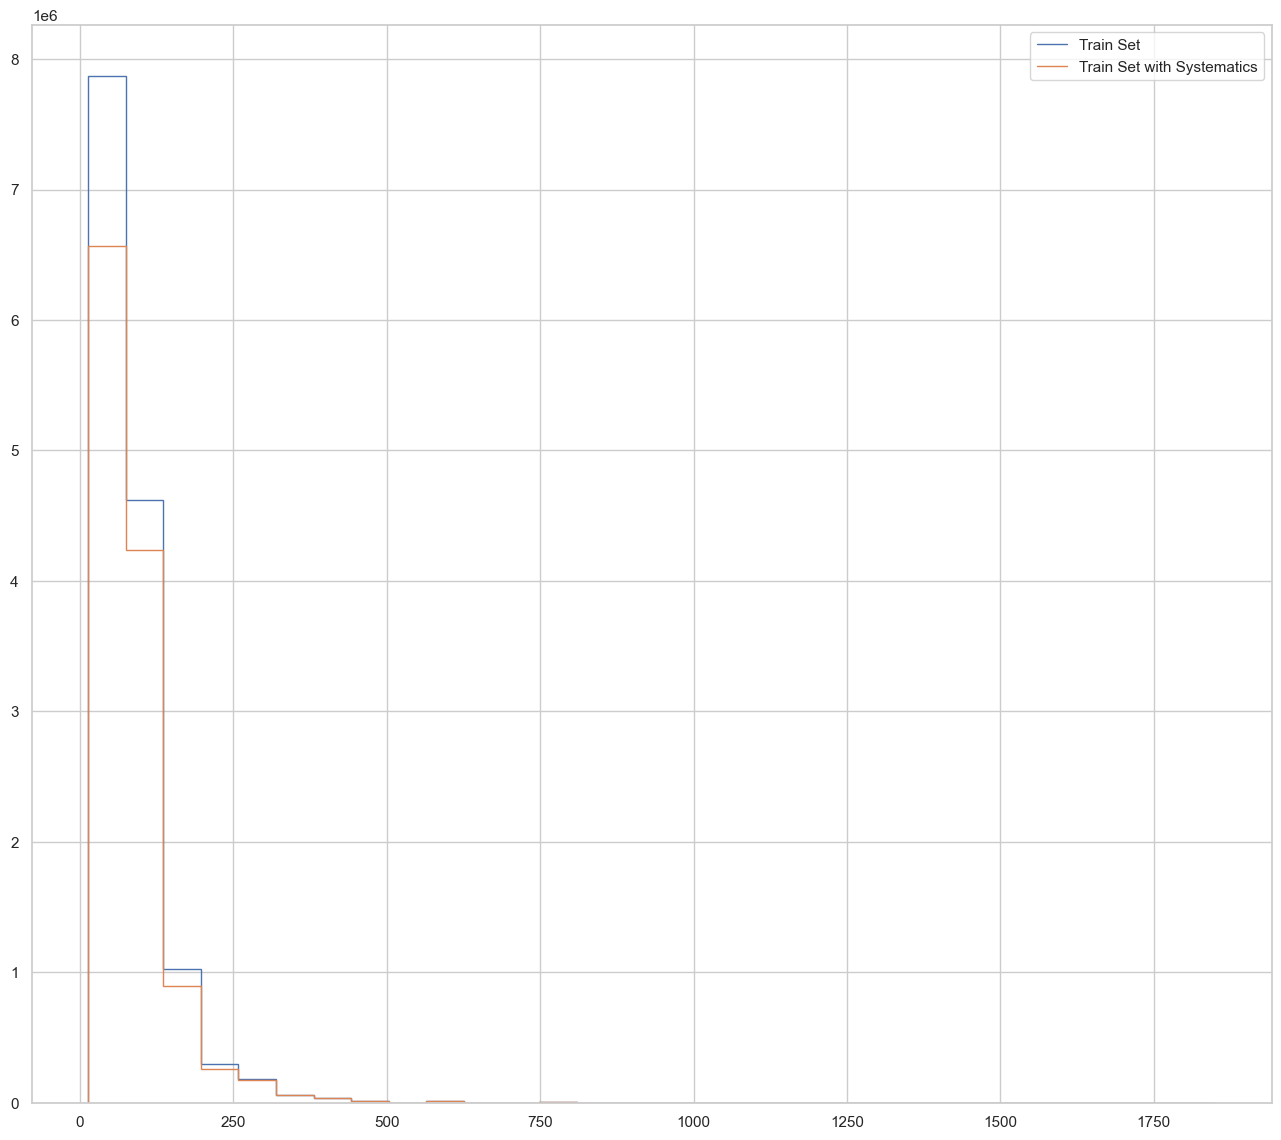

In [19]:
# Pair plots of train set with systematics
histgram_compare(data.get_train_set(), syst_train_data, "DER_deltar_had_lep", plot_label=["Train Set", "Train Set with Systematics"])

In [20]:
bootstraped_data = data.generate_psuedo_exp_data()

In [21]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 587494
[*] --- Number of features : 28
   diboson   2398563.89547613
   htautau   285.4734133092692
   ttbar   616016.6584148749
   wjets   3812700.198884666
   ztautau   7306659.692678657
[*] --- Number of signal events : 495643
[*] --- Number of background events : 91851
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,35.806999,1.991,-0.586,79.801003,1.018,-0.785,185.875000,-0.360,2.885,183.020996,...,331.662994,2.146,37.54,-0.642,0.993,179.164001,596.429993,0.449,1.387,0.242
1,22.094999,1.109,0.400,59.280998,-0.234,-1.971,59.280998,-0.234,-1.971,33.278999,...,51.948002,3.079,-0.00,-0.667,2.725,112.456001,228.888000,0.373,-1.027,0.984
2,20.530001,-0.033,0.061,38.776001,-1.074,3.078,38.776001,-1.074,3.078,-7.000000,...,8.513000,-7.000,-7.00,-7.000,3.192,8.513000,98.081001,0.529,-0.574,-7.000
3,21.837999,-1.549,2.619,24.382000,-2.313,0.101,24.382000,-2.313,0.101,-7.000000,...,12.154000,-7.000,-7.00,-7.000,2.632,12.154000,70.602997,0.896,-1.342,-7.000
4,44.200001,0.108,1.663,37.803001,1.800,-2.030,37.803001,1.800,-2.030,34.285999,...,23.562000,2.232,-0.00,-0.778,3.093,36.768002,154.093002,1.169,-1.227,0.767


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,...,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000,587494.000000
mean,41.518753,0.001016,-0.002035,51.806934,0.001662,0.001886,78.463570,0.000256,-0.000307,36.703117,...,66.652428,-0.742022,10.778684,-2.133732,2.540747,51.703873,242.151810,0.949479,0.409354,-1.869865
std,25.259804,1.165208,1.813845,28.462002,1.198698,1.813327,59.886684,1.551047,1.813591,41.375164,...,70.351128,4.316102,30.836983,4.099448,0.707789,56.638672,161.216248,0.698054,1.128382,3.416090
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.919001,-4.924000,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679001,0.034000,-1.414000,-7.000000
25%,26.245001,-0.881000,-1.572000,34.428001,-0.916000,-1.567000,43.144001,-1.113000,-1.573000,-7.000000,...,18.753000,-7.000000,-7.000000,-7.000000,2.091000,15.371000,134.697006,0.535000,-0.926000,-7.000000
50%,34.261002,0.001000,-0.004000,45.257000,0.003000,0.007000,58.615002,0.001000,0.000000,33.932499,...,41.754002,0.945000,-0.000000,-1.184000,2.762000,32.466000,188.473007,0.772000,1.044000,0.005000
75%,47.282001,0.884000,1.570000,59.625000,0.921000,1.569750,90.880747,1.113000,1.569000,55.430000,...,90.250999,2.372000,15.208000,0.616000,3.072000,70.410753,299.408997,1.131000,1.369000,0.563000
max,1026.430054,2.500000,3.142000,778.645996,2.681000,3.142000,1166.640015,4.924000,3.142000,696.237000,...,1167.008057,7.845000,817.351000,14.638000,5.829000,1797.446045,2939.478027,23.846001,1.414000,1.000000


In [22]:
print("sum of weights = ", (bootstraped_data["weights"]).sum())

sum of weights =  3377524.0


***
### Program
***


In [23]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [24]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submitted Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587494 entries, 0 to 587493
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 74.0 MB
None
[*] Train data loaded successfully
Full data:  (587494, 28)
Full Labels:  (587494,)
Full Weights:  (587494,)
sum_signal_weights:  285.4734133092692
sum_bkg_weights:  14133940.445454327
 
 
Full size of the data is 587494
Train size is 356063
Test size is 293747
Training Data:  (356063, 28)
Training Labels:  (356063,)
Training Weights:  (356063,)
sum_signal_weights:  285.47341330926906
sum_bkg_weights:  14133940.44545433

Valid Data:  (293747, 28)
Valid Labels:  (293747,)
Valid Weights:  (293747,)
sum_signal_weights:  285.47341330926923
sum_bkg_weights:  14133940.445454327
 
 
Training Data:  (356063, 28)


2024-06-09 13:42:41.417485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 13:42:41.448766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 13:42:41.448793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 13:42:41.449486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 13:42:41.453861: I tensorflow/core/platform/cpu_feature_guar

Model is TF NN


[*] Calling fit method of submitted model
11127/11127 [==============================] - 22s 2ms/step


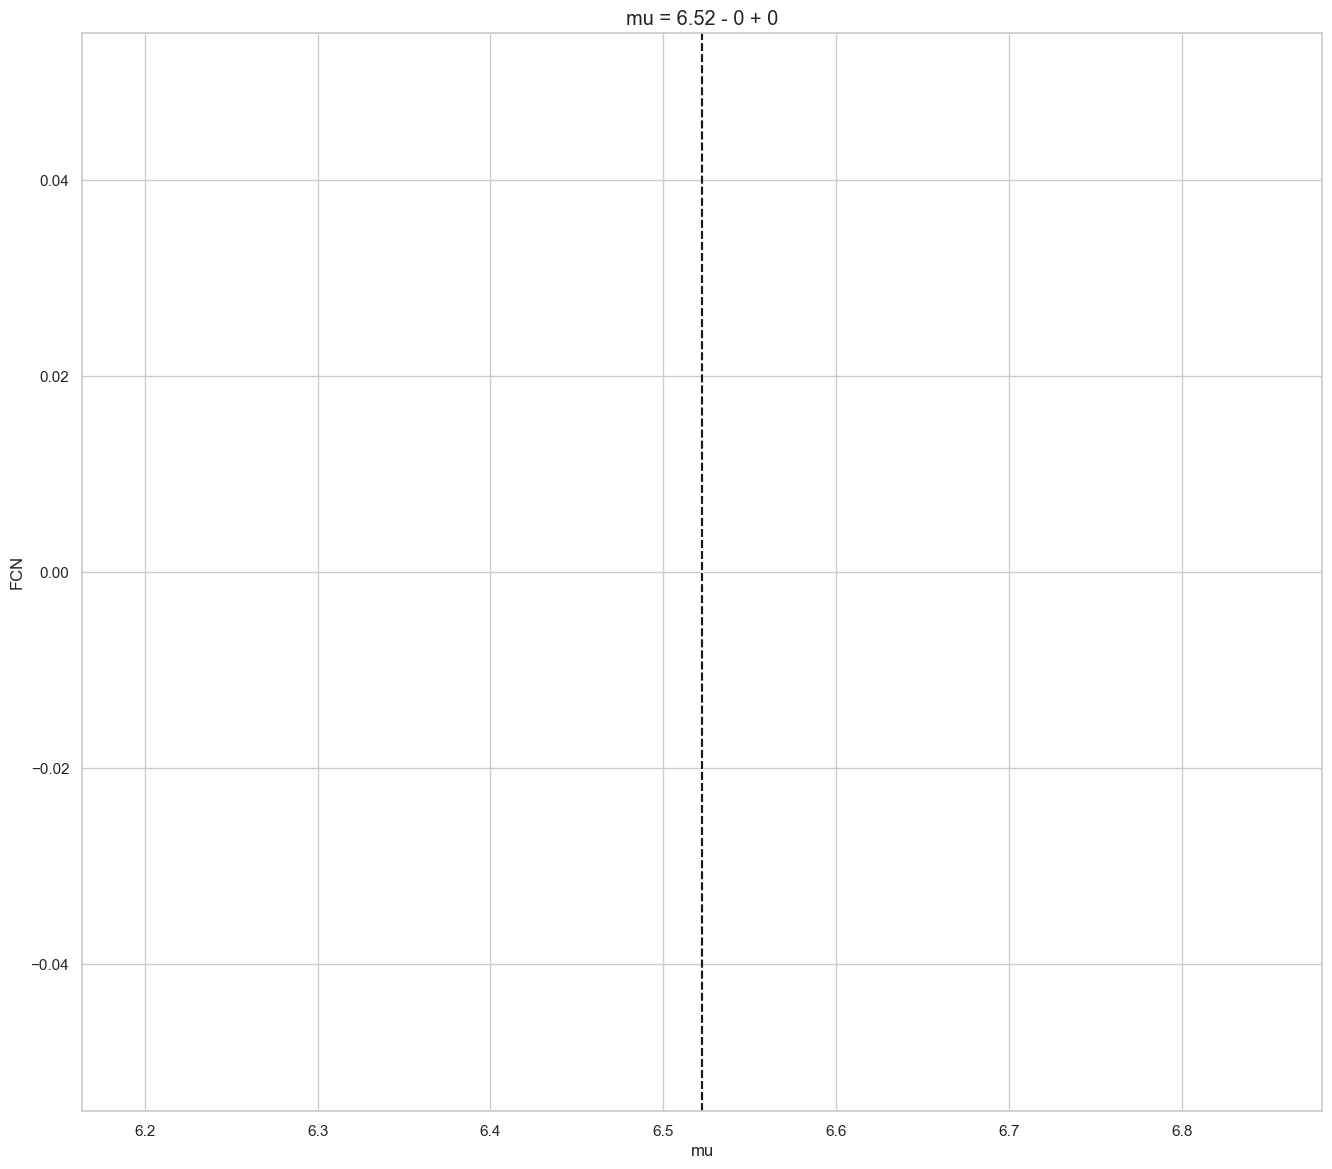

Train Results: 
	 mu_hat  :  6.522598765219584
	 delta_mu_hat  :  0.0
	 p16  :  6.522598765219584
	 p84  :  6.522598765219584


In [25]:

# fit submission
ingestion.fit_submission()

In [26]:

# load test set
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


In [27]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
 28096/100276 [=======>......................] - ETA: 2:22

In [ ]:
ingestion.compute_result()

[*] Saving ingestion result


In [ ]:

# save result
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def visualize_coverage(ingestion_result_dict, ground_truth_mus):

    for key in ingestion_result_dict.keys():
        plt.figure( figsize=(5, 5))

        ingestion_result = ingestion_result_dict[key]
        mu = ground_truth_mus[key]
        mu_hats = np.mean(ingestion_result["mu_hats"])
        p16s = ingestion_result["p16"]
        p84s = ingestion_result["p84"]
        
        # plot horizontal lines from p16 to p84
        for i, (p16, p84) in enumerate(zip(p16s, p84s)):
            plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

        plt.vlines(x=mu_hats, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed', label='Predicted $\mu$')
        plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='g', linestyles='dashed', label='Ground Truth $\mu$')
        plt.xlabel('mu')
        plt.ylabel('psuedo-experiments')
        plt.title(f'mu distribution - Set_{key}')
        plt.legend()
        
    plt.show()


In [ ]:
from score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
score.load_ingestion_results(output_dir)

[*] Reading predictions
[✔]


[*] Computing scores
[*]  [{'mu_hats': [-1021.2832582312597, -938.5319627372886], 'delta_mu_hats': [13.850724260986453, 13.594141983675513], 'p16': [-1028.2086203617528, -945.3290337291264], 'p84': [-1014.3578961007663, -931.7348917454508]}, {'mu_hats': [-4642.8585946574585, -4505.657140489208], 'delta_mu_hats': [47.77631956158257, 50.66745009643637], 'p16': [-4666.74675443825, -4530.9908655374265], 'p84': [-4618.970434876667, -4480.32341544099]}, {'mu_hats': [-1030.0068773283, -4736.138708553995], 'delta_mu_hats': [13.965918957700751, 51.57841855476045], 'p16': [-1036.9898368071506, -4761.9279178313745], 'p84': [-1023.0239178494498, -4710.349499276614]}, {'mu_hats': [-919.4926099457662, -1054.8916450252486], 'delta_mu_hats': [14.117127320585496, 13.80998794988875], 'p16': [-926.5511736060589, -1061.796639000193], 'p84': [-912.4340462854734, -1047.9866510503043]}, {'mu_hats': [-1058.5211805046818, -1022.3723538355212], 'delta_mu_hats': [12.193382937107685, 14.333716034108534], 'p16': [

[*] mu_hats: {'mu_hats': [-4642.8585946574585, -4505.657140489208], 'delta_mu_hats': [47.77631956158257, 50.66745009643637], 'p16': [-4666.74675443825, -4530.9908655374265], 'p84': [-4618.970434876667, -4480.32341544099]}
------------------
Set 1
------------------
MAE (avg): 9103.197897315638
RMSE (avg): 20943978.643357616
Interval: 49.22188482900947
Coverage: 0.0
Quantiles Score: -3.8963893128590597
[*] mu_hats: {'mu_hats': [-1030.0068773283, -4736.138708553995], 'delta_mu_hats': [13.965918957700751, 51.57841855476045], 'p16': [-1036.9898368071506, -4761.9279178313745], 'p84': [-1023.0239178494498, -4710.349499276614]}
------------------
Set 2
------------------
MAE (avg): 5733.696926694889
RMSE (avg): 11745467.554803368
Interval: 32.772168756230826
Coverage: 0.0
Quantiles Score: -3.4896408136031187
[*] mu_hats: {'mu_hats': [-919.4926099457662, -1054.8916450252486], 'delta_mu_hats': [14.117127320585496, 13.80998794988875], 'p16': [-926.5511736060589, -1061.796639000193], 'p84': [-912

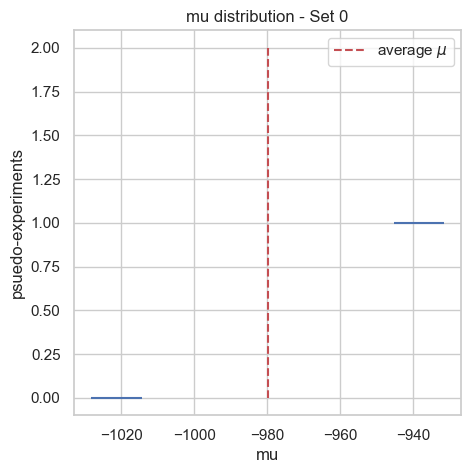

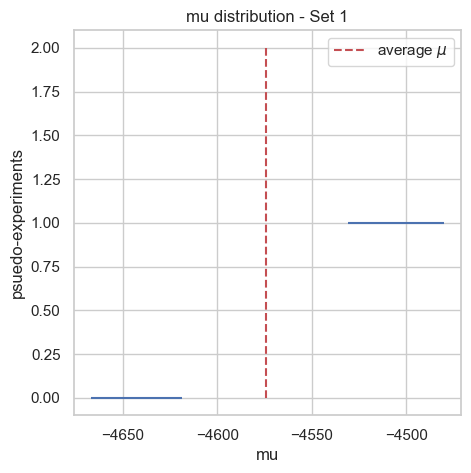

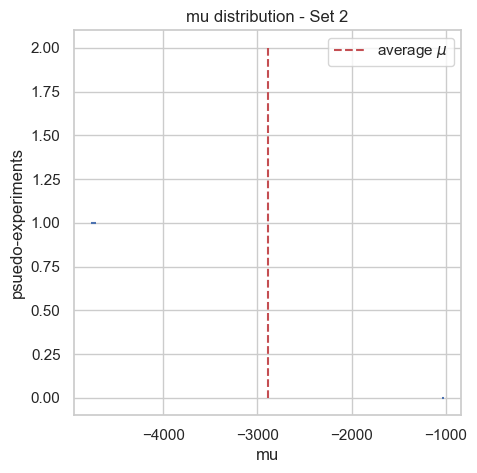

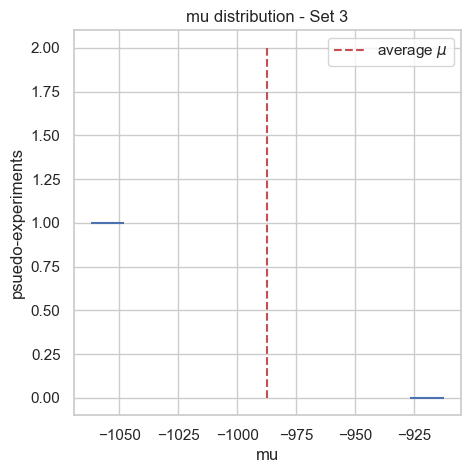

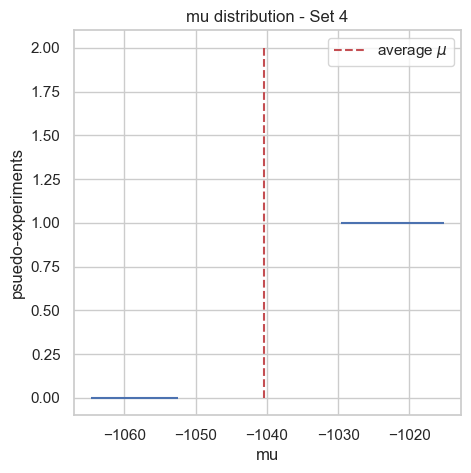

In [ ]:
# Compute Score
score.compute_scores(test_settings)

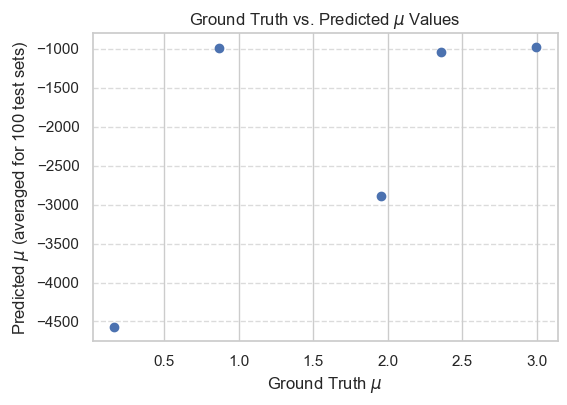

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

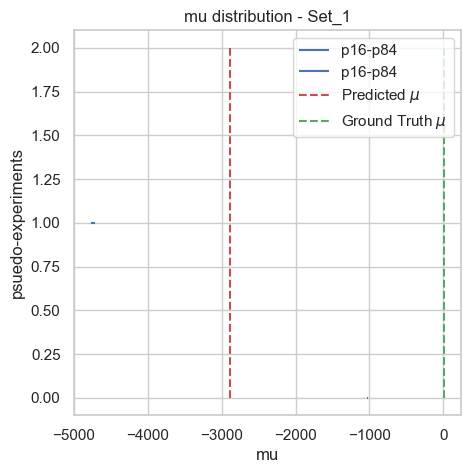

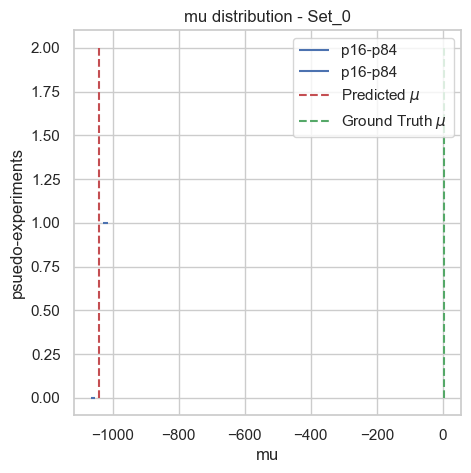

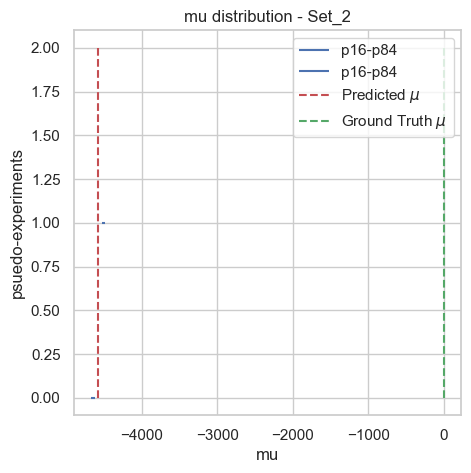

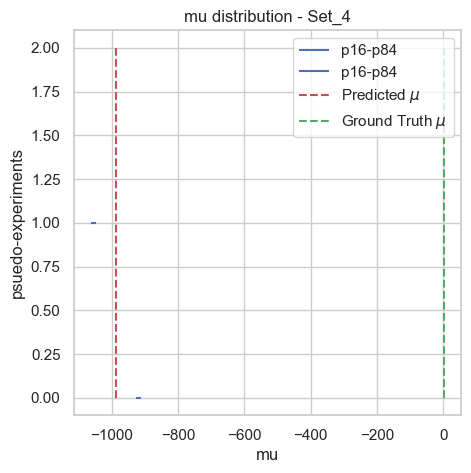

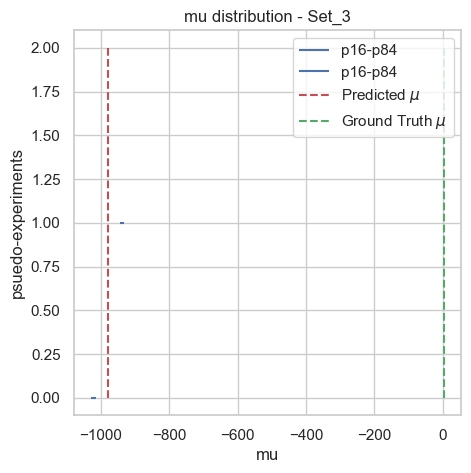

In [ ]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

Submit : HiggsML-code_submission_24-06-06-20-47.zip to the competition
You can find the zip file in `HEP-Challenge/
